<h2>Figure 5</h2>

In [16]:
# 1. Load Libraries
library(tidyverse)

In [17]:
# 1. Load Data
raw_data <- read.csv("data/data.csv")

In [18]:
# 1. Age Group Function (IARC Standard)
create_age_groups <- function(age) {
  case_when(
    age >= 15 & age <= 19 ~ "15-19",
    age >= 20 & age <= 24 ~ "20-24",
    age >= 25 & age <= 29 ~ "25-29",
    age >= 30 & age <= 34 ~ "30-34",
    age >= 35 & age <= 39 ~ "35-39",
    age >= 40 & age <= 44 ~ "40-44",
    age >= 45 & age <= 49 ~ "45-49",
    age >= 50 & age <= 54 ~ "50-54",
    age >= 55 & age <= 59 ~ "55-59",
    age >= 60 & age <= 64 ~ "60-64",
    age >= 65 & age <= 69 ~ "65-69",
    age >= 70 & age <= 74 ~ "70-74",
    age >= 75 & age <= 79 ~ "75-79",
    age >= 80 & age <= 84 ~ "80-84",
    age >= 85 ~ "85+",
    TRUE ~ "Other"
  )
}

In [19]:
# 1. Corrected Population Processing
pop_raw <- read.csv("data/population_pichincha.csv", check.names = FALSE)
pop_long <- pop_raw %>%
  mutate(
    Age_Num = suppressWarnings(as.numeric(as.character(Edad))),
    AgeGroup = create_age_groups(if_else(Edad == "100 y más", 100, Age_Num))
  ) %>%
  # We filter out "Other" (ages < 15) to match the study cohort logic
  filter(AgeGroup != "Other") %>%
  pivot_longer(cols = -c(Edad, Age_Num, AgeGroup), names_to = "Year", values_to = "Pop_Raw") %>%
  mutate(
    Year = as.numeric(Year),
    Pop = as.numeric(gsub(",", "", Pop_Raw))
  )
head(pop_long)

Edad,Age_Num,AgeGroup,Year,Pop_Raw,Pop
<chr>,<dbl>,<chr>,<dbl>,<int>,<dbl>
15,15,15-19,1990,36064,36064
15,15,15-19,1991,36540,36540
15,15,15-19,1992,37048,37048
15,15,15-19,1993,37638,37638
15,15,15-19,1994,38400,38400
15,15,15-19,1995,39323,39323


In [20]:
# 2. Corrected Baseline Population (Sum within group per year, then average years)
pop_baseline <- pop_long %>%
  filter(Year >= 2015 & Year <= 2019) %>%
  group_by(Year, AgeGroup) %>%
  summarise(Total_Year_Group_Pop = sum(Pop, na.rm = TRUE), .groups = 'drop') %>%
  group_by(AgeGroup) %>%
  summarise(Avg_Pop = mean(Total_Year_Group_Pop, na.rm = TRUE))
head(pop_baseline)

AgeGroup,Avg_Pop
<chr>,<dbl>
15-19,258724.4
20-24,270073.0
25-29,279966.0
30-34,274239.2
35-39,248221.8
40-44,211060.6


In [6]:
# 3. Corrected 2035 Population (Sum within group)
pop_2035 <- pop_long %>%
  filter(Year == 2035) %>%
  group_by(AgeGroup) %>%
  summarise(Pop_2035 = sum(Pop, na.rm = TRUE))

In [7]:
# 4. Corrected Case Aggregation (Filtering for adults >= 15/18)
baseline_cases <- raw_data %>%
  filter(Anio_diag >= 2015 & Anio_diag <= 2019) %>%
  mutate(
    Age = as.numeric(Anio_diag) - as.numeric(Anio_nac),
    AgeGroup = create_age_groups(Age)
  ) %>%
  filter(AgeGroup != "Other") %>%
  group_by(AgeGroup) %>%
  summarise(Avg_Cases = n() / 5)

In [8]:
# 5. Final Join and Calculation
substitution_table <- baseline_cases %>%
  left_join(pop_baseline, by = "AgeGroup") %>%
  left_join(pop_2035, by = "AgeGroup") %>%
  mutate(
    Rate_per_100k = (Avg_Cases / Avg_Pop) * 100000,
    Projected_Cases_2035 = (Rate_per_100k * Pop_2035) / 100000
  )

In [9]:
# 6. Final Results Output
total_current <- sum(substitution_table$Avg_Cases)
total_projected <- sum(substitution_table$Projected_Cases_2035)
pct_increase <- ((total_projected - total_current) / total_current) * 100

message("Corrected Results (IARC Standard):")
message(paste("Current Avg Annual Cases (2015-2019):", round(total_current, 1)))
message(paste("Projected Annual Cases in 2035:", round(total_projected, 1)))
message(paste("% Increase due to Aging/Growth:", round(pct_increase, 1), "%"))

# Review the table to confirm rates are realistic (usually between 5 and 500 per 100k)
print(substitution_table)

Corrected Results (IARC Standard):

Current Avg Annual Cases (2015-2019): 247

Projected Annual Cases in 2035: 473.2

% Increase due to Aging/Growth: 91.6 %



# A tibble: 15 × 6
   AgeGroup Avg_Cases Avg_Pop Pop_2035 Rate_per_100k Projected_Cases_2035
   <chr>        <dbl>   <dbl>    <dbl>         <dbl>                <dbl>
 1 15-19          5   258724.   231735          1.93                 4.48
 2 20-24          5.6 270073    256653          2.07                 5.32
 3 25-29          5.6 279966    259653          2.00                 5.19
 4 30-34          9.4 274239.   254395          3.43                 8.72
 5 35-39         11.6 248222.   265943          4.67                12.4 
 6 40-44         12.6 211061.   276459          5.97                16.5 
 7 45-49         14.2 174504.   281169          8.14                22.9 
 8 50-54         18.6 146062.   262836         12.7                 33.5 
 9 55-59         21.8 123338.   227657         17.7                 40.2 
10 60-64         21.4 100115.   185524         21.4                 39.7 
11 65-69         28.2  76620.   147304         36.8                 54.2 
12 70-74         28

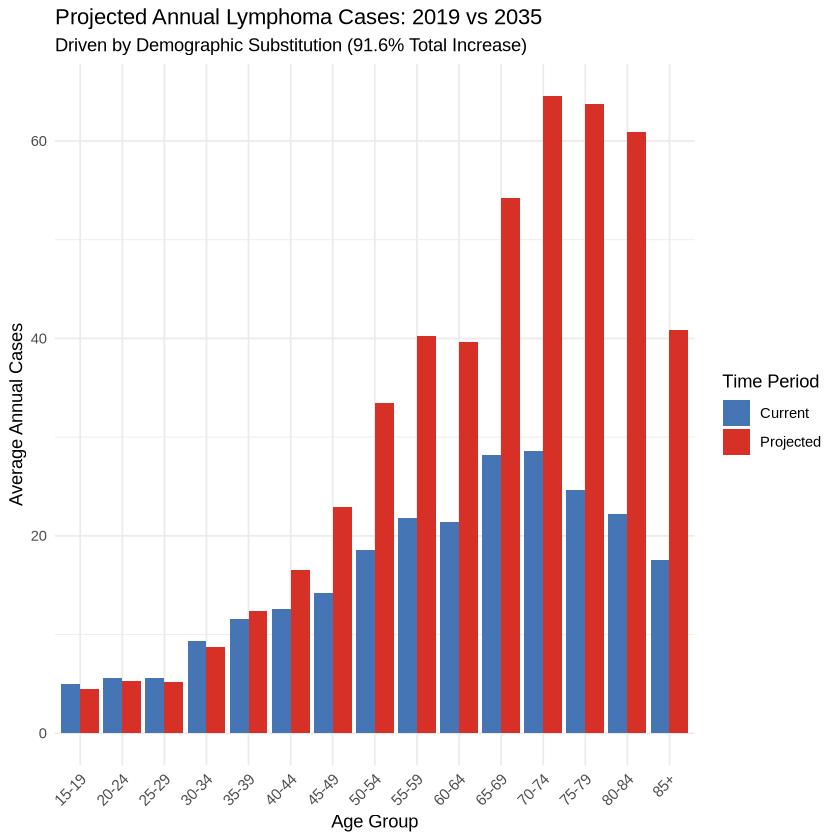

In [10]:
# Prepare data for plotting
plot_data <- substitution_table %>%
  select(AgeGroup, Current = Avg_Cases, Projected = Projected_Cases_2035) %>%
  pivot_longer(cols = c(Current, Projected), names_to = "Period", values_to = "Cases")

# Create the plot
ggplot(plot_data, aes(x = AgeGroup, y = Cases, fill = Period)) +
  geom_bar(stat = "identity", position = "dodge") +
  theme_minimal() +
  scale_fill_manual(values = c("Current" = "#4575b4", "Projected" = "#d73027")) +
  labs(
    title = "Projected Annual Lymphoma Cases: 2019 vs 2035",
    subtitle = "Driven by Demographic Substitution (91.6% Total Increase)",
    x = "Age Group",
    y = "Average Annual Cases",
    fill = "Time Period"
  ) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))



Warning message in geom_bar(stat = "identity", position = "dodge", alpha = 0.85, :
“Ignoring unknown parameters: `size`”


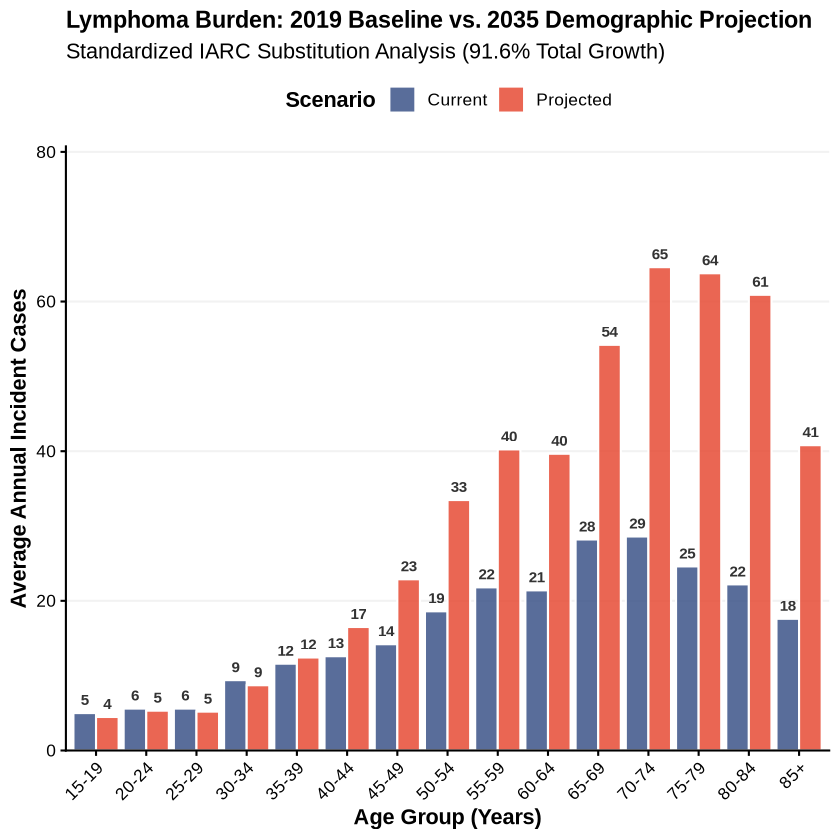

In [15]:


# 2. Final Publication Plot
ggplot(plot_data, aes(x = AgeGroup, y = Cases, fill = Period)) +
  geom_bar(stat = "identity", position = "dodge", alpha = 0.85, color = "white", size = 0.2) +
  
  # CHANGE: Labels are now rounded to the nearest whole number (integers)
  geom_text(aes(label = sprintf("%.0f", Cases)), 
            position = position_dodge(width = 0.9), 
            vjust = -0.8, 
            size = 3.2, 
            fontface = "bold", 
            color = "grey20") +
  
  # Nature-inspired color palette
  scale_fill_manual(values = c("Current" = "#3C5488", "Projected" = "#E64B35")) +
  
  # Expansion to prevent clipping at the top
  scale_y_continuous(expand = expansion(mult = c(0, 0.25))) + 
  coord_cartesian(clip = "off") + 
  
  # Professional Journal Styling
  theme_classic(base_size = 13) + 
  labs(
    title = "Lymphoma Burden: 2019 Baseline vs. 2035 Demographic Projection",
    subtitle = "Standardized IARC Substitution Analysis (91.6% Total Growth)",
    x = "Age Group (Years)",
    y = "Average Annual Incident Cases",
    fill = "Scenario"
  ) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, color = "black"),
    axis.title = element_text(face = "bold"),
    legend.position = "top",
    legend.title = element_text(face = "bold"),
    plot.title = element_text(face = "bold", size = 14),
    panel.grid.major.y = element_line(color = "grey95")
  )
# Save for the appendix
ggsave("images/Figure_5_Projected_Burden.png", width = 8, height = 5)

<h2>Supplementary Table S4. <h2></h2>

In [12]:
# 1. Load Required Libraries
library(flextable)
library(officer)
library(dplyr)

Warning message:
“package ‘flextable’ was built under R version 4.3.3”

Attaching package: ‘flextable’


The following object is masked from ‘package:purrr’:

    compose


Warning message:
“package ‘officer’ was built under R version 4.3.3”


In [13]:
# 2. Prepare the Table Data
# (Assuming 'substitution_table' from the previous step is in your environment)
table_data <- substitution_table %>%
  # We select and rename columns for a professional appearance
  select(
    `Age Group` = AgeGroup,
    `Observed Annual Cases (2015-2019)` = Avg_Cases,
    `Baseline Population (Pichincha)` = Avg_Pop,
    `Incidence Rate (per 100,000)` = Rate_per_100k,
    `Projected Population 2035 (Pichincha)` = Pop_2035,
    `Projected Annual Cases (2035)` = Projected_Cases_2035
  )

In [14]:
# 3. Create the Professional Flextable
ft <- flextable(table_data) %>%
  # Round numbers for a clean look
  colformat_double(j = c(2, 6), digits = 1) %>% # Cases with 1 decimal
  colformat_double(j = c(3, 5), digits = 0, big.mark = ",") %>% # Population as integers
  colformat_double(j = 4, digits = 2) %>% # Rates with 2 decimals
  
  # Styling
  autofit() %>%
  bold(part = "header") %>%
  align(align = "center", part = "all") %>%
  align(j = 1, align = "left", part = "all") %>% # Left-align the Age Group
  
  # Add Title and Footnotes
  add_header_lines(values = "Supplementary Table S4. Demographic Substitution Analysis for 2035") %>%
  add_footer_lines(values = c(
    "Note: Baseline reflects the annual average of cases in Quito (2015-2019).",
    "Population data for Pichincha province used as a regional demographic proxy.",
    "Methodology: IARC standard demographic substitution (Rates held constant)."
  )) %>%
  
  # Standard Academic Borders
  border_remove() %>%
  hline_top(part = "header", border = fp_border(width = 2)) %>%
  hline_bottom(part = "header", border = fp_border(width = 1)) %>%
  hline_bottom(part = "body", border = fp_border(width = 2))

# 4. View and Export
print(ft)

# To save this directly to a Word document:
 save_as_docx(ft, path = "tables/Table_S4_Projections.docx")

a flextable object.
col_keys: `Age Group`, `Observed Annual Cases (2015-2019)`, `Baseline Population (Pichincha)`, `Incidence Rate (per 100,000)`, `Projected Population 2035 (Pichincha)`, `Projected Annual Cases (2035)` 
header has 2 row(s) 
body has 15 row(s) 
original dataset sample: 
'data.frame':	15 obs. of  6 variables:
 $ Age Group                            : chr  "15-19" "20-24" "25-29" "30-34" ...
 $ Observed Annual Cases (2015-2019)    : num  5 5.6 5.6 9.4 11.6 12.6 14.2 18.6 21.8 21.4 ...
 $ Baseline Population (Pichincha)      : num  258724 270073 279966 274239 248222 ...
 $ Incidence Rate (per 100,000)         : num  1.93 2.07 2 3.43 4.67 ...
 $ Projected Population 2035 (Pichincha): num  231735 256653 259653 254395 265943 ...
 $ Projected Annual Cases (2035)        : num  4.48 5.32 5.19 8.72 12.43 ...
